In [45]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import *

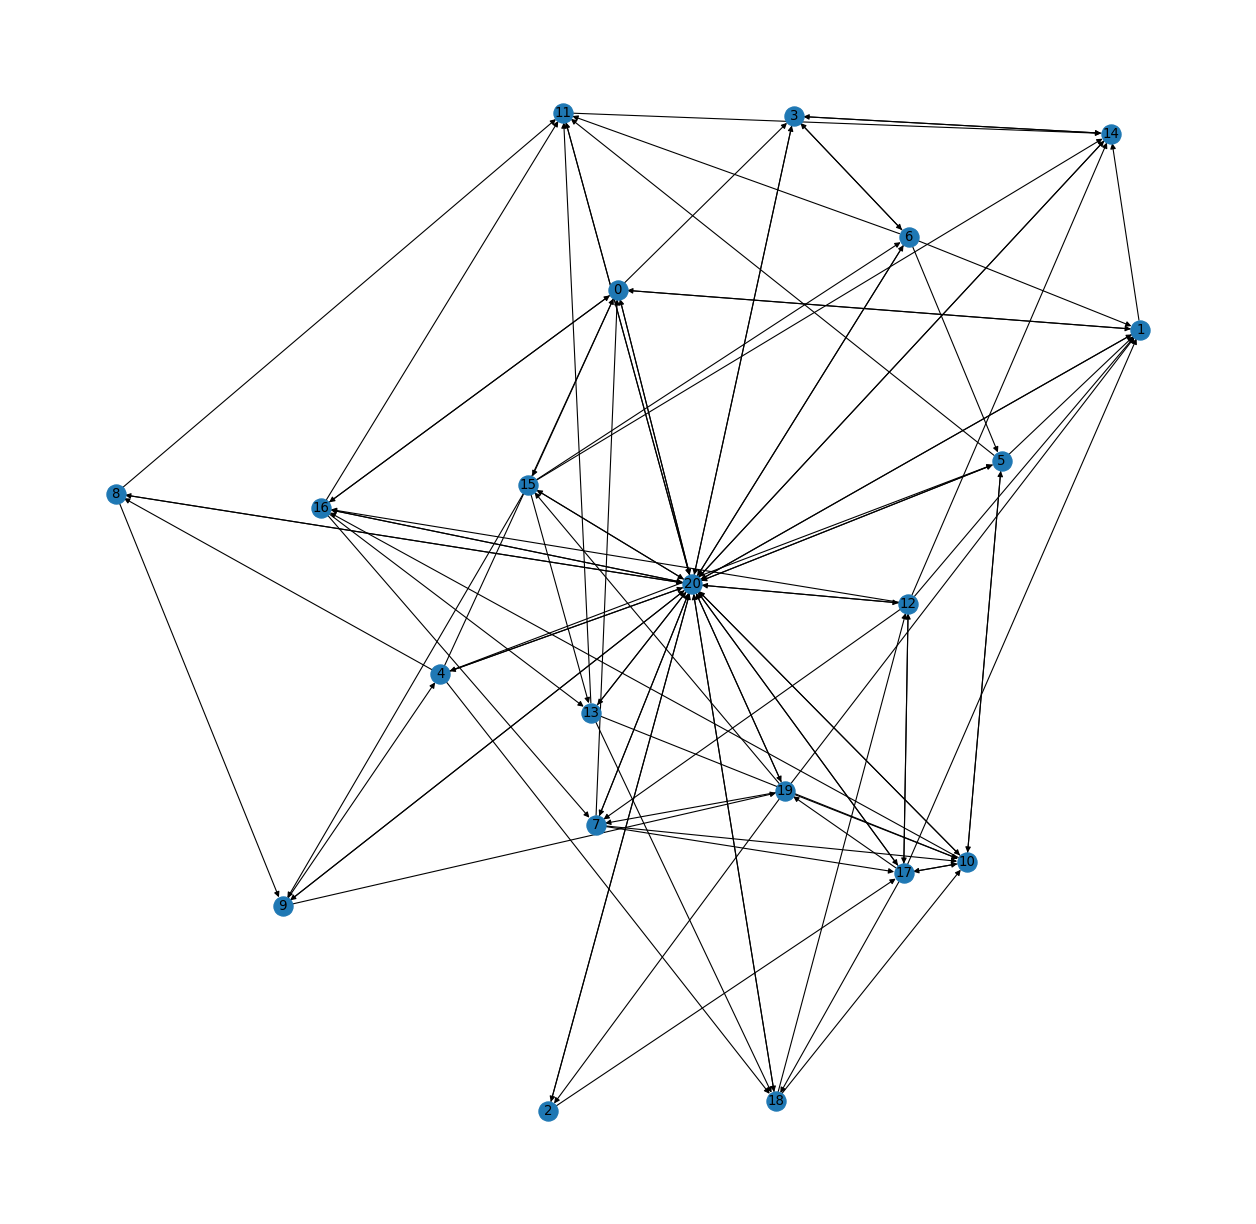

In [46]:
num_nodes = 20
num_edges = 60
super_node = num_nodes
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
G = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
G.add_node(num_nodes)
for i in range(num_nodes):
    G.add_edge(i, super_node)
    G.add_edge(super_node, i)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True)

In [47]:
for node in G:
    print(node, end=':')
    for nbr in G[node]:
        print(nbr, end=',')
    print()

0:16,15,1,3,20,
1:14,0,20,
2:17,20,
3:14,6,20,
4:5,0,18,8,20,
5:1,10,11,20,
6:3,11,5,1,20,
7:10,17,0,20,
8:9,11,20,
9:19,4,20,
10:5,16,17,20,
11:14,20,
12:7,16,1,14,17,20,
13:18,10,11,20,
14:3,20,
15:9,6,13,14,20,
16:7,11,13,0,20,
17:1,10,12,18,19,20,
18:10,12,20,
19:7,15,2,1,10,20,
20:0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,


In [48]:
for node in G:
    num_nbr = len(G[node])
    if num_nbr == 1:
        G[node][super_node]['weight'] = 1
    else:
        if node != super_node:
            for nbr in G[node]:
                G[node][nbr]['weight'] = 0.85 / (num_nbr - 1)
            G[node][super_node]['weight'] = 0.15
        else:
            for nbr in G[node]:      
                G[node][nbr]['weight'] = 1 / num_nbr

# Simulation

Simulate the process at each node for `num_iter` times, at each node, we take a weighted probabilty based on the edge weight

given sufficiently large `n`, this should give us a good approximation of 
the stationery distribution of the graph on a random walk

In [49]:
curr = super_node
num_iter = 0
count = [0 for _ in range(21)]
N = 10 ** 7
while num_iter < N:
    p = random()
    n = 0
    for nbr in G[curr]:   
        n += G[curr][nbr]['weight']
        if n > p:
            curr = nbr
            break
    count[curr] += 1
    num_iter += 1

rank_s = [(entry / N, i) for i, entry in enumerate(count)]
rank_s.sort(key = lambda x : -x[0])
print(rank_s)

[(0.1609734, 3), (0.1503329, 14), (0.1304887, 20), (0.0791746, 6), (0.0578209, 1), (0.0506827, 11), (0.0469965, 10), (0.0467731, 0), (0.0393727, 5), (0.0377276, 17), (0.0335125, 16), (0.0216982, 12), (0.0207524, 18), (0.0205784, 7), (0.0197755, 15), (0.0191907, 19), (0.0177778, 13), (0.0146609, 9), (0.0127028, 4), (0.0097848, 2), (0.0092229, 8)]


# Stationary Distribution & Page Rank
Let $r_i$ denote the rank of each note, and we can define 
$$ \lambda_{i,j} = \begin{cases}
    0 & \text{ if there is no edge from $j$ to $i$,} \\
    \frac{1}{\text{outdeg}(j)} & \text{otherwise.}
\end{cases} $$
with some algebraic maniupluation we can see that
$$ r_i = \sum_{j != i}^n \lambda_{i,j} r_j \implies \sum_{j != i}^n \lambda_{i,j} r_j - r_i = 0$$
hence we can fit all the rank equation into an equation of the form $Ar = b$ as followed
$$ 
\begin{bmatrix}
-1 & \lambda_{1,2} & \lambda_{1,3} & \cdots & \lambda_{1,n} \\
\lambda_{2,1} & -1 & \lambda_{2,3} & \cdots & \lambda_{2,n} \\
\lambda_{3,1} & \lambda_{3,2} & -1 & \cdots & \lambda_{3,n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\lambda_{n,1} & \lambda_{n,2} & \lambda_{n,3} & \cdots & -1 \\
1 & 1 & 1 & \cdots & 1
\end{bmatrix}
\begin{bmatrix}
r_1 \\ r_2 \\\vdots \\ r_n 
\end{bmatrix} = 
\begin{bmatrix}
0 \\ 0 \\ \vdots \\ 1
\end{bmatrix}
$$
where the last row is the constraint $\sum_{i} r_i = 1$. Then to solve for $r$, we simply take the puesudo inverse of $A^{\dagger}$, and we have $r = (A^\dagger)^{-1} b$

In [50]:
def find_incoming_nodes(node, G):
    return [edge[0] for edge in G.edges if edge[1] == node]


A = np.zeros((num_nodes + 2, num_nodes + 1))
for x in range(num_nodes + 1):
    A[x][x] = -1
    incoming_nodes = find_incoming_nodes(x, G)
    for y in incoming_nodes:
        A[x][y] = 1 / len(G[y])
for x in range(num_nodes + 1):
    A[num_nodes + 1][x] = 1
    
b = np.zeros((num_nodes + 2, 1))
b[-1] = 1

ainv = np.linalg.pinv(A)
x = np.matmul(ainv,b)

rank_c = [(x[i][0], i) for i in range(len(x))]
rank_c.sort(key = lambda x : -x[0])
print(rank_c)

[(0.22996227650169807, 20), (0.08878622353075666, 14), (0.07393882424102692, 3), (0.055776544137442874, 10), (0.05562916973179372, 1), (0.04895921790942317, 0), (0.048359744184219414, 11), (0.045333897610865155, 17), (0.04127877534339685, 6), (0.04001861295931581, 16), (0.03744524674721611, 5), (0.028960061043049486, 18), (0.02870711710791216, 12), (0.028668332384477847, 7), (0.026291858697266815, 19), (0.025671933856514045, 15), (0.024636223188250737, 13), (0.02171428581111301, 9), (0.018736209095456053, 4), (0.015880090274629194, 2), (0.01524535564417621, 8)]


In [51]:
relative_order_s = [r[1] for r in rank_s]
relative_order_c = [r[1] for r in rank_c]

print(relative_order_s)
print(relative_order_c)

[3, 14, 20, 6, 1, 11, 10, 0, 5, 17, 16, 12, 18, 7, 15, 19, 13, 9, 4, 2, 8]
[20, 14, 3, 10, 1, 0, 11, 17, 6, 16, 5, 18, 12, 7, 19, 15, 13, 9, 4, 2, 8]


C:\Users\billc\AppData\Local\Temp/ipykernel_16152/2182065614.py:17: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(2 * x * np.log(np.log(x)))
C:\Users\billc\AppData\Local\Temp/ipykernel_16152/2182065614.py:17: RuntimeWarning: invalid value encountered in log
  return np.sqrt(2 * x * np.log(np.log(x)))
C:\Users\billc\AppData\Local\Temp/ipykernel_16152/2182065614.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * x * np.log(np.log(x)))
C:\Users\billc\AppData\Local\Temp/ipykernel_16152/2182065614.py:17: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(2 * x * np.log(np.log(x)))
C:\Users\billc\AppData\Local\Temp/ipykernel_16152/2182065614.py:17: RuntimeWarning: invalid value encountered in log
  return np.sqrt(2 * x * np.log(np.log(x)))
C:\Users\billc\AppData\Local\Temp/ipykernel_16152/2182065614.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * x * np.log(np.log(x)))


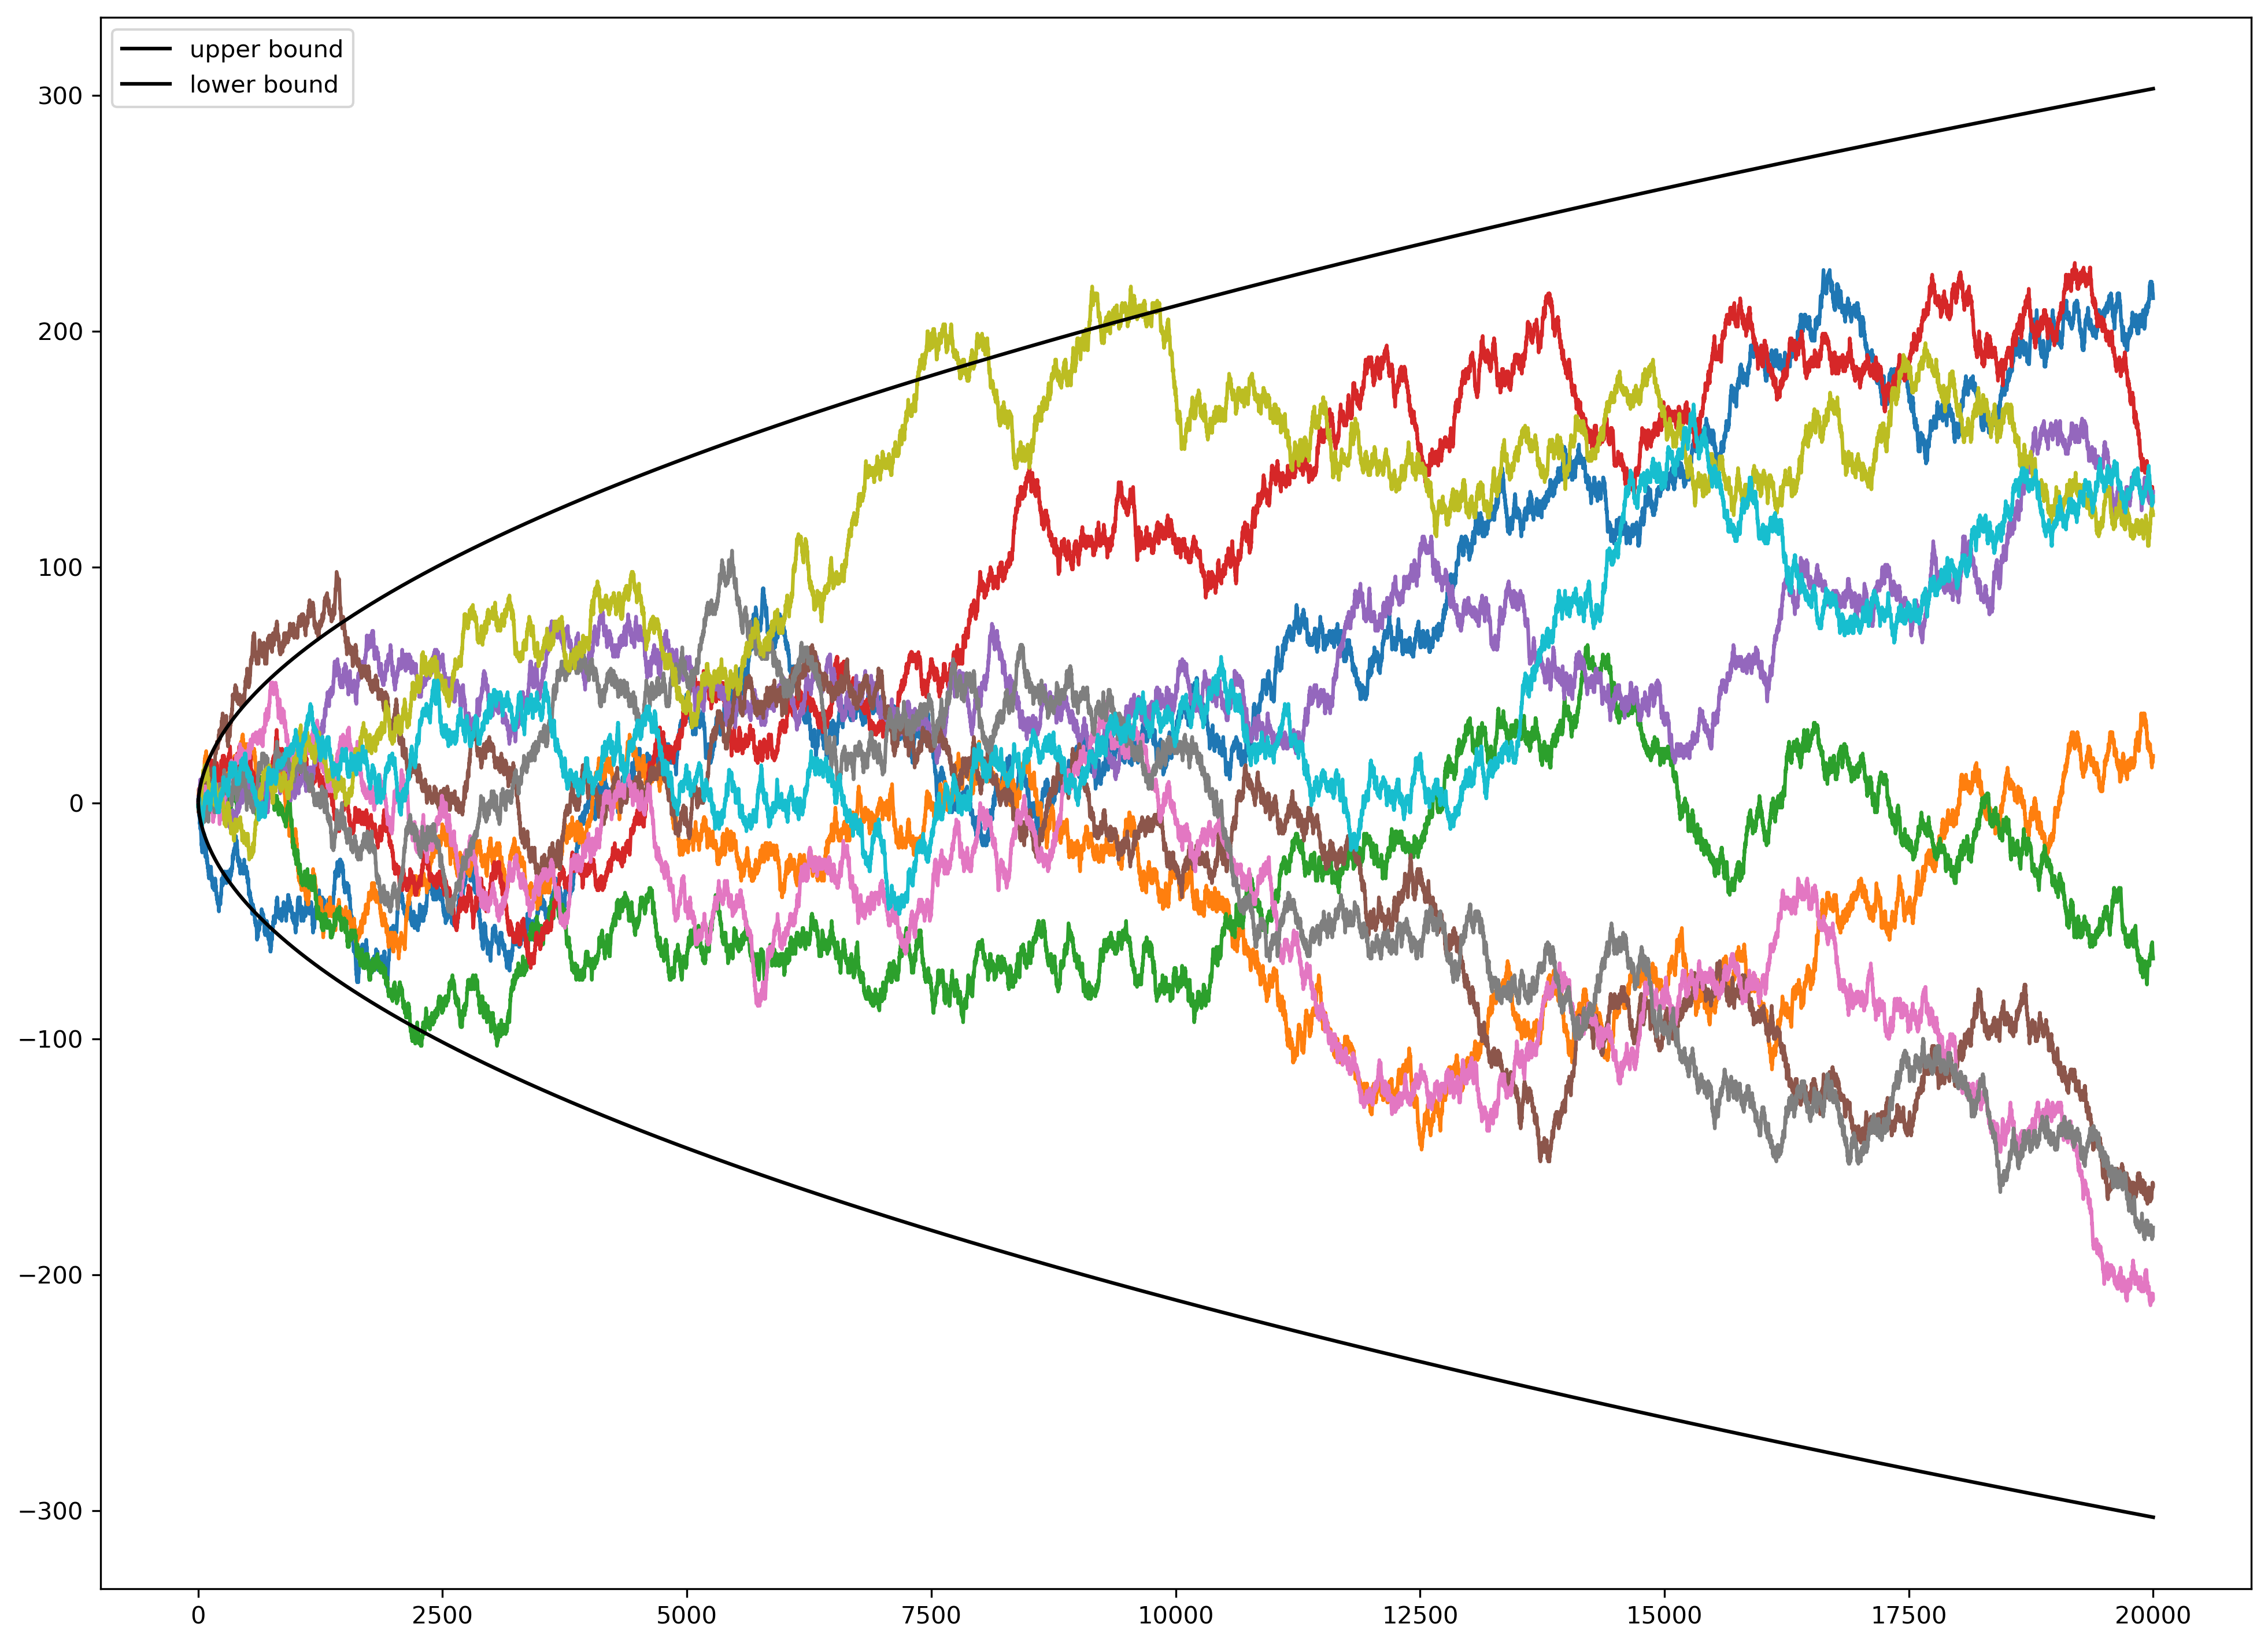

In [58]:
import numpy as np
import matplotlib.pyplot as plt

nwalks = 10
nsteps = 20000

draws = np.random.randint(0,2, size=(nwalks, nsteps))
steps = np.where(draws > 0, 1, -1)
walks = steps.cumsum(1)
fig = plt.figure(figsize=(16,12), dpi = 300)
ax = fig.add_subplot(111)

for i in range(nwalks):
    ax.plot(walks[i])
    
def f(x):
    return np.sqrt(2 * x * np.log(np.log(x)))

x = np.linspace(0,nsteps,nsteps)

plt.plot(x, f(x), color = 'black', label = 'upper bound')
plt.plot(x, -f(x), color = 'black', label = 'lower bound')
plt.legend()
plt.show()

In [ ]:
x = y/2 + z/3
y = x/5 + z/2
z = x/4 + y/3
x+y+z = 1

1